In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from esn import *
from utils import *

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
from itertools import product

In [4]:
from typing import Callable

In [5]:
key = jax.random.PRNGKey(123)

### Definitions

In [6]:
class TrainingConfig(NamedTuple):
    T_washout: int
    opt_wout: Optimizer
    fun_loading: Callable
    w_loading_regularizer: float
    fun_conceptor: Callable
    fun_conceptor_x_init: Callable
    conceptor_aperture: float

In [7]:
# functions to load reservoir
def loading_ridge_report(X, X_, B, N, regularizer_w):
    return jnp.dot(
        jnp.linalg.inv(jnp.dot(X_.T, X_) + regularizer_w * jnp.eye(N)),
        jnp.dot(X_.T, jnp.arctanh(X)-B)
    )

In [8]:
# functions to compute conceptor
def compute_conceptor(X, aperture):
    R = jnp.dot(X.T, X) / X.shape[0]
    return jnp.dot(
        R, 
        jnp.linalg.inv(
            R + aperture ** (-2) * jnp.eye(R.shape[0])
        )
    )

In [9]:
def pipeline(key, ut, esn_config: ESNConfig, config: TrainingConfig):
    """
    Trains ESN on identity function.
    
    :param key: PRNG key from JAX
    :param ut: list of input patterns, each of (T, L)
    :param esn_config: ESNConfig tuple
    :param config: TrainingConfig tuple
    """
    esn = ESN(key, esn_config)
    # pass each pattern through network
    xt, yt = v_harvest_states(esn, ut)
    # concatenate patterns along time
    X  = concatenate_patterns(xt, config.T_washout)
    U  = concatenate_patterns(ut, config.T_washout)
    
    # compute output weights
    esn.update_weights(X, U, U.copy(), optimizer=config.opt_wout) # TODO: y_target?
    # harvest trained states and outputs
    xt_trained, yt_trained = v_harvest_states(esn, ut)
    
    # load the weight matrix (need shifted X_tilde and B)
    X_ = concatenate_patterns(xt, config.T_washout, shift=-1)
    B = jnp.repeat(esn.b, X_.shape[0], axis=1).T
    W_loaded = config.fun_loading(X, X_, B, esn_config.reservoir_size, config.w_loading_regularizer)
    W_before_loading = esn.w.copy()
    esn.w = W_loaded.copy()
    # test the loaded reservoir with zero input
    ut_loaded_zero = jnp.zeros_like(U)
    xt_loaded_zero, yt_loaded_zero = esn.harvest_states(ut_loaded_zero)
    
    # compute conceptor
    xt_loaded, yt_loaded = v_harvest_states(esn, ut)
    Ci = [
        config.fun_conceptor(xt_loaded_i[config.T_washout:, :], config.conceptor_aperture)
        for xt_loaded_i in xt_loaded
    ]
    # test the loaded reservoir with the conceptor
    xt_conceptor, yt_conceptor = [], []
    for i in range(len(ut)):
        xt_tmp, yt_tmp = esn.harvest_states(
            jnp.zeros_like(ut[i]), 
            x_init=config.fun_conceptor_x_init(key, (esn_config.reservoir_size, 1)), 
                        # jax.random.uniform(key, (dim_reservoir, 1))
            C=Ci[i]
        )
        xt_conceptor.append(xt_tmp)
        yt_conceptor.append(yt_tmp)
#     xt_conceptor, yt_conceptor = tuple([list(e) for e in zip(*[esn.harvest_states(
#             jnp.zeros_like(ut[i]), 
#             x_init=config.fun_conceptor_x_init(key, (esn_config.reservoir_size, 1)), 
#             C=Ci[i]
#         )
#         for i in range(len(ut))
#     ])])

    return (
        xt, yt, # lists
        xt_trained, yt_trained, # lists
        xt_loaded_zero, yt_loaded_zero, # single arrays
        xt_loaded, yt_loaded, # lists
        xt_conceptor, yt_conceptor # lists
    )

In [10]:
def init_win_uniform(minval=-1., maxval=1.):
    return lambda key, shape: jax.random.uniform(key, shape, minval=minval, maxval=maxval)
def init_win_normal(scale=1.):
    return lambda key, shape: jax.random.normal(key, shape) * scale

In [11]:
def init_w_uniform(minval=-1., maxval=1.):
    return lambda key, shape: jax.random.uniform(key, shape, minval=minval, maxval=maxval)
def init_w_normal(density=0.5, scale=1.):
    def f(key, shape):
        arr = jax.random.normal(key, shape) * scale
        arr = arr.at[jax.random.uniform(key, shape) > density].set(0.)
        return arr
    return f

In [12]:
def init_b_normal(scale=1.):
    return lambda key, shape: jax.random.normal(key, shape) * scale

In [13]:
def sample_between(key, minval, maxval, n):
    # TODO: add log scale?
#     if log:
#         return jnp.exp(jax.random.uniform(key, (n,), minval=jnp.log(minval), maxval=jnp.log(maxval)))
#     else:
    return jax.random.uniform(key, (n,), minval=minval, maxval=maxval)

### Input

In [14]:
T_pattern = 1500
n_pattern = 3
T = T_pattern * n_pattern

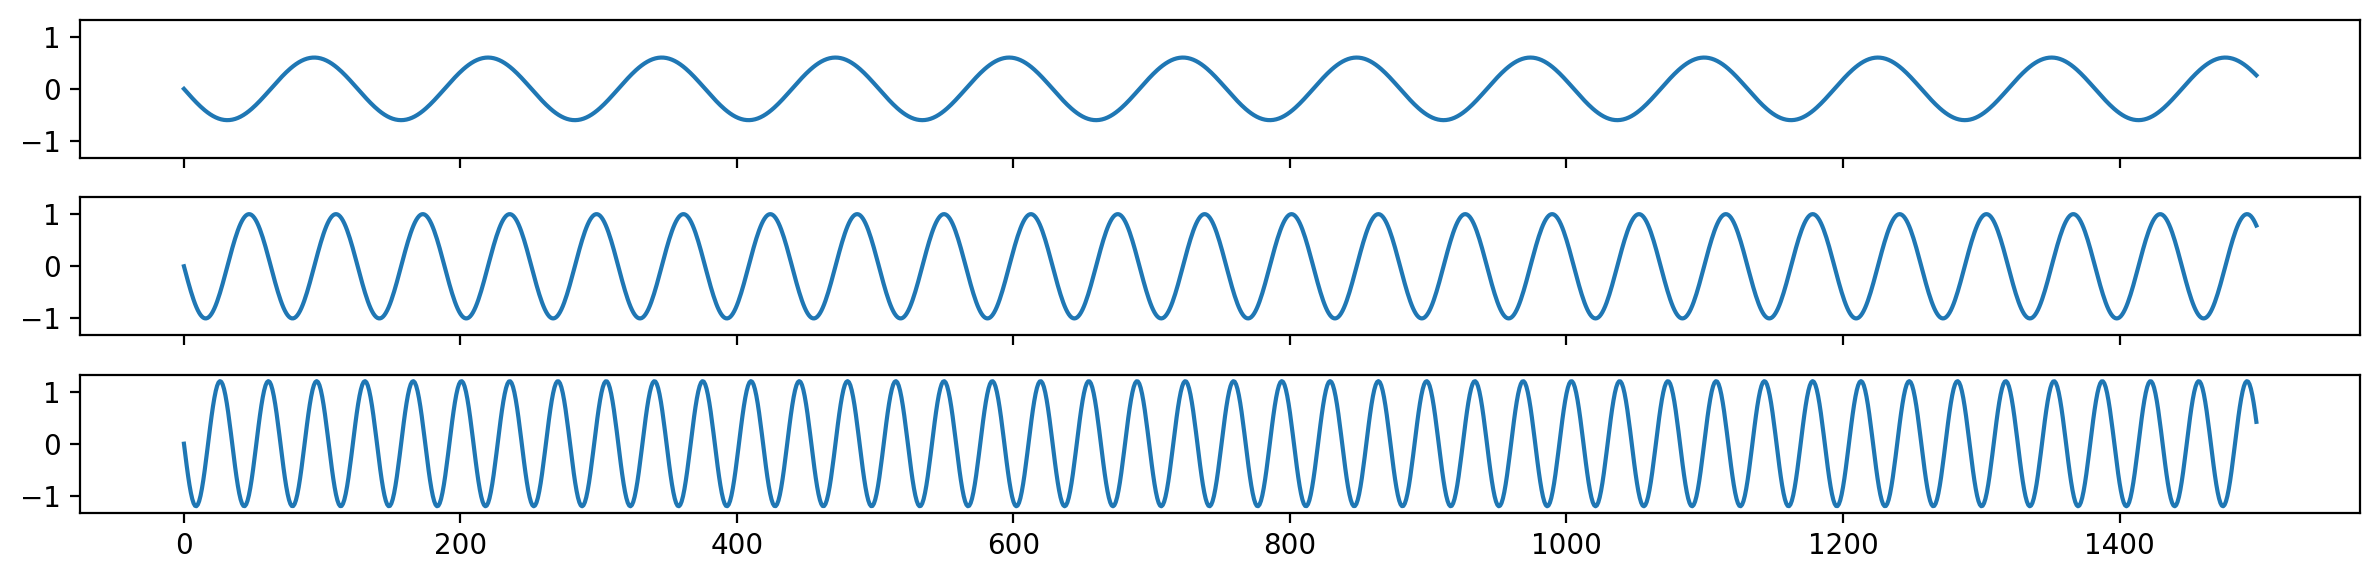

In [15]:
dt = 0.1
ut = [
    sine(T_pattern*dt, dt, 0.6, 0.5, 1.0), # (T_pattern, 1)
    sine(T_pattern*dt, dt, 1.0, 1.0, 1.0),
    sine(T_pattern*dt, dt, 1.2, 1.8, 1.0)
]
plot_inputs(ut)

### Parameters

In [16]:
hyperparams_grid = {
    'esn_fun_init_win': [
        init_win_normal(scale=1.5), # Jaeger2014 report
    ],
    'esn_fun_init_b': [
        init_b_normal(scale=0.2), # Jaeger2014 report
    ],
    'esn_fun_init_w': [
        init_w_normal(density=0.1), # Jaeger2014 report (use rho=1.5 instead of scaling it here)
    ],
    'esn_spectral_radius': [
        1.5, # Jaeger2014 report
    ],
    'opt_wout': [
        LinearRegression()
        # TODO: fix and add ridge regression
    ],
    'fun_loading': [
        loading_ridge_report, # Jaeger2014 report
    ],
    'fun_conceptor': [
        compute_conceptor, # Jaeger2014 report
    ],
    'fun_conceptor_init': [
        # This is not specified anywhere! Use normal distribution (mu=0, std=1)
        jax.random.normal,
    ],
    'w_loading_regularizer': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3],
        # sample_between(key, 1e-3, 1e-5, n=5), # default: 1e-4
    'conceptor_aperture': [0.5, 1., 2.5, 5., 10., 15., 20.]
        # sample_between(key, 1., 20., n=10), # default: 10
}

In [17]:
# turn grid into list of hyperparams (dict)
list_hyperparams = [dict(zip(hyperparams_grid.keys(), e)) for e in product(*hyperparams_grid.values())]
len(list_hyperparams)

35

In [18]:
# fixed params
esn_input_size = 1
esn_reservoir_size = 100
esn_output_size = 1
esn_feedback = False
train_T_washout = 100

In [19]:
hyperparams = list_hyperparams[0]

In [20]:
esn_config = ESNConfig(
    input_size      = esn_input_size,
    reservoir_size  = esn_reservoir_size,
    output_size     = esn_output_size,
    feedback        = esn_feedback,
    init_weights    = hyperparams['esn_fun_init_w'], # jax.random.uniform
    init_weights_in = hyperparams['esn_fun_init_win'], # jax.random.uniform
    init_weights_b  = hyperparams['esn_fun_init_b'], # jax.random.uniform
    rho             = hyperparams['esn_spectral_radius'], 
)
config = TrainingConfig(
    T_washout             = train_T_washout,
    opt_wout              = hyperparams['opt_wout'],
    w_loading_regularizer = hyperparams['w_loading_regularizer'],
    fun_loading           = hyperparams['fun_loading'],
    fun_conceptor         = hyperparams['fun_conceptor'],
    fun_conceptor_x_init  = hyperparams['fun_conceptor_init'], # lambda key, n: jax.random.uniform(key, (n, 1))
    conceptor_aperture    = hyperparams['conceptor_aperture']
)

In [21]:
data = pipeline(key, ut, esn_config, config)

In [22]:
(xt, yt, xt_trained, yt_trained, xt_loaded_zero, yt_loaded_zero, 
 xt_loaded, yt_loaded, xt_conceptor, yt_conceptor) = data